# **Klasifikasi Gambar Binatang**
---
### **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mendeteksi/klasifikasi dari suatu gambar.

### **Sumber Dataset yang digunakan:**
https://www.kaggle.com/datasets/alessiocorrado99/animals10?resource=download

---

## Imports

---

In [1]:
# Standard libraries
import os
import shutil
import zipfile
import random
import warnings
from pathlib import Path
from collections import Counter
from io import BytesIO
import requests

# Data manipulation & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Image processing
import cv2
from PIL import Image
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, mixed_precision
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    InputLayer, Input, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    img_to_array, load_img, ImageDataGenerator
)
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
from tensorflow.keras.applications import (
    EfficientNetB0
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import AdamW

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Progress bars
from tqdm.notebook import tqdm

# Inline plots for Jupyter
%matplotlib inline

# Suppress warnings
warnings.filterwarnings('ignore')


2025-04-28 07:30:57.230261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745825457.413470      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745825457.466564      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

# Data Loading

---

In [3]:
selected_classes = {
    "elefante": "elephant",
    "ragno": "spider",
    "farfalla": "butterfly"
}


source_dir = "/kaggle/input/animals10/raw-img"
destination_dir = "/kaggle/working/submission/livestock_filtered"

os.makedirs(destination_dir, exist_ok=True)

for it_name, id_name in selected_classes.items():
    src = os.path.join(source_dir, it_name)
    dst = os.path.join(destination_dir, id_name)
    shutil.copytree(src, dst)

train_ds = image_dataset_from_directory(
    destination_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    destination_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 8379 files belonging to 3 classes.
Using 6704 files for training.


I0000 00:00:1745825528.050690      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 8379 files belonging to 3 classes.
Using 1675 files for validation.


Correct class order used: ['butterfly', 'elephant', 'spider']


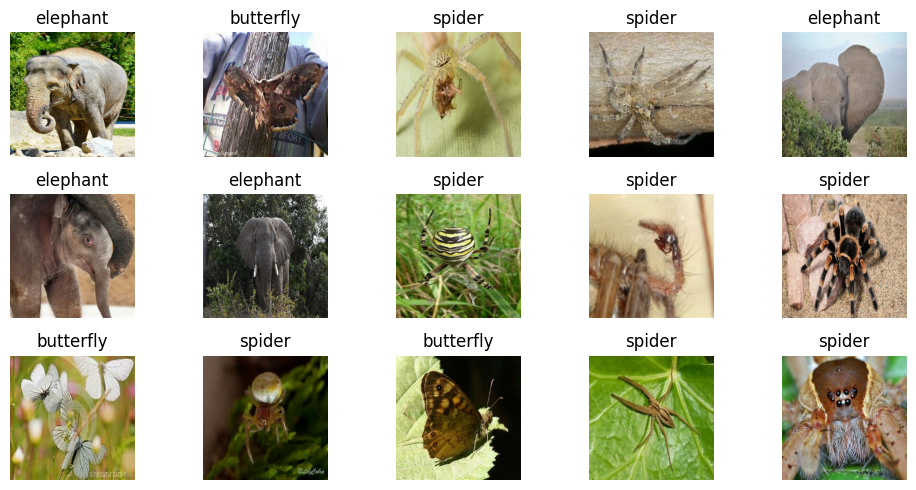

In [4]:
class_names = train_ds.class_names
print("Correct class order used:", class_names)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        label_index = np.argmax(labels[i].numpy())
        class_name = class_names[label_index]

        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


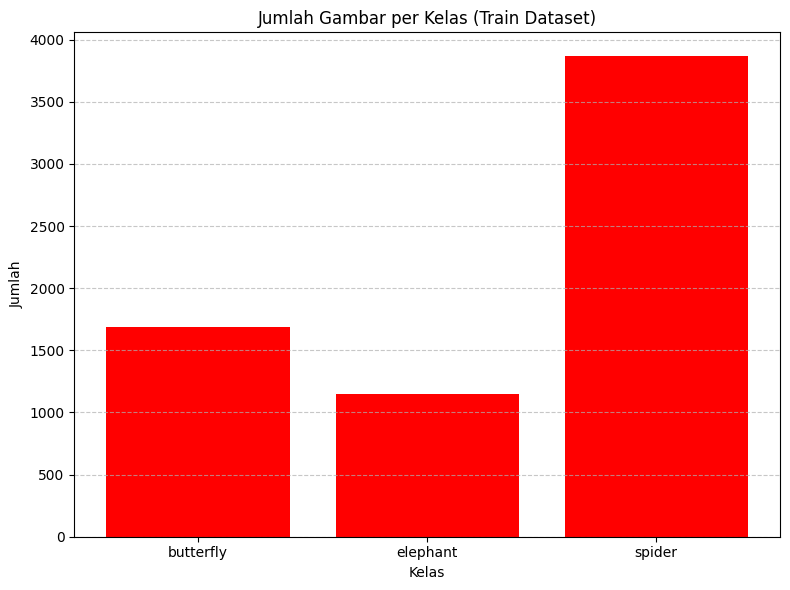

total : Counter({2: 3865, 0: 1690, 1: 1149})


In [5]:
label_counts = Counter()

for _, labels in train_ds:
    class_indices = np.argmax(labels.numpy(), axis=1)
    label_counts.update(class_indices)

class_counts = {class_names[i]: label_counts[i] for i in range(len(class_names))}

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='red')
plt.title("Jumlah Gambar per Kelas (Train Dataset)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"total : {label_counts}")

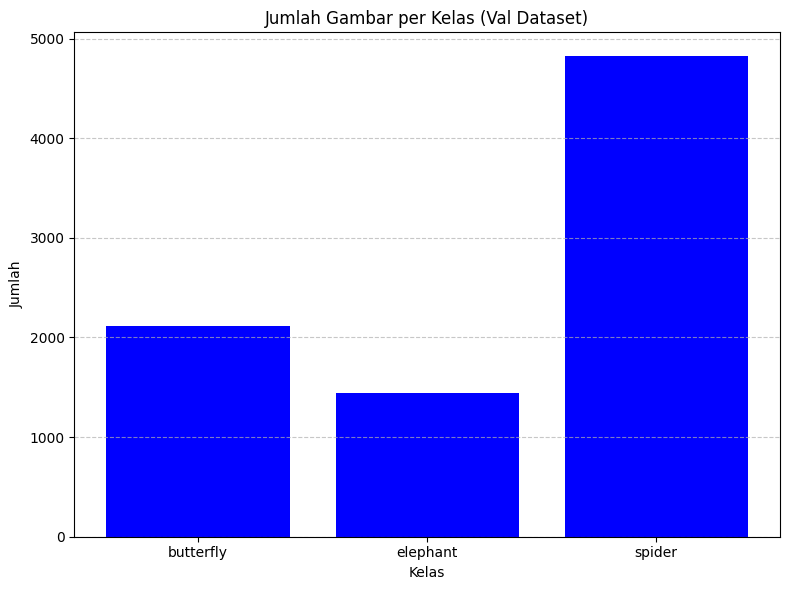

total : {'butterfly': 2112, 'elephant': 1446, 'spider': 4821}


In [6]:
for _, labels in val_ds:
    class_indices = np.argmax(labels.numpy(), axis=1)
    label_counts.update(class_indices)

class_counts = {class_names[i]: label_counts[i] for i in range(len(class_names))}

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title("Jumlah Gambar per Kelas (Val Dataset)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"total : {class_counts}")

In [7]:
classes = ['butterfly', 'elephant', 'spider']

# Data Augmentation

---

In [8]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

input_base_path = "/kaggle/working/submission/livestock_filtered"
target = 1500

for cls in classes:
    images_path = f"{input_base_path}/{cls}"
    augmented_path = images_path  
    images = []  

    for im in os.listdir(images_path):
        images.append(os.path.join(images_path, im))

    images_to_generate = target
    i = 1

    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)

            
            if original_image.ndim not in [3, 4]:
                raise ValueError('Invalid image dimensions')

            transformed_image = None
            n = 0  
            transformation_count = random.randint(1, len(transformations))  

            while n <= transformation_count:
                key = random.choice(list(transformations))  
                transformed_image = transformations[key](original_image)
                n = n + 1

            new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
            transformed_image = img_as_ubyte(transformed_image)  
            cv2.imwrite(new_image_path, transformed_image)  
            i = i + 1
        except ValueError as e:
            print('Could not read or process the image', image, ':', e, 'hence skipping it.')

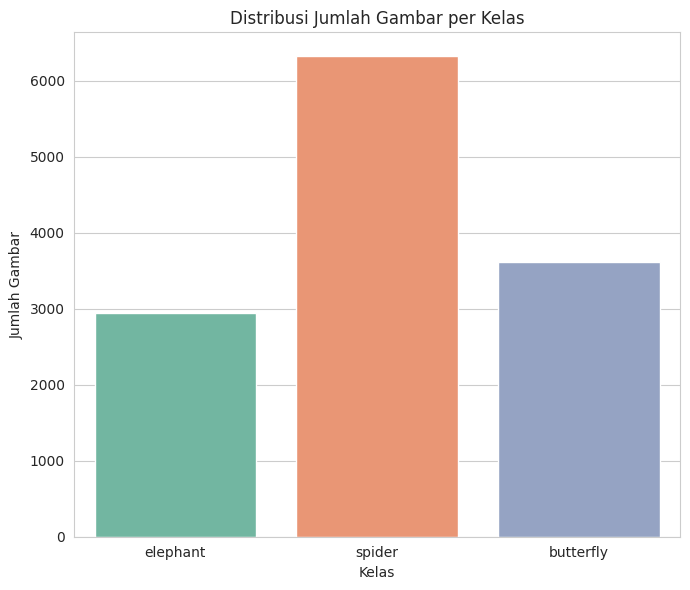

In [10]:
datasource_path = "/kaggle/working/submission/livestock_filtered/"
os.makedirs("/kaggle/working/submission/Dataset-Final", exist_ok=True)
dataset_path = "/kaggle/working/submission/Dataset-Final/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(datasource_path):
    for name in files:
        if name.lower().endswith((".jpg", ".jpeg", ".png")):  
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])  
            file_name.append(name)

distribution_df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

plt.figure(figsize=(7, 6))
sns.set_style("whitegrid")
sns.countplot(x='labels', data=distribution_df, palette='Set2')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

# Data Splitting

---

In [11]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(datasource_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

df.groupby(['labels']).size()

labels
butterfly    3612
elephant     2946
spider       6321
dtype: int64

In [12]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [13]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [14]:
print('train size', len(df_tr))
print('test size', len(df_te))

train size 10303
test size 2576


In [15]:

df_all = pd.concat([df_tr, df_te], ignore_index=True)
print(df_all.groupby(['set', 'labels']).size())

set    labels   
test   butterfly     722
       elephant      579
       spider       1275
train  butterfly    2890
       elephant     2367
       spider       5046
dtype: int64


In [16]:
def extract_label(path):
    path_lower = path.lower()
    if "elephant" in path_lower:
        return "elephant"
    elif "spider" in path_lower:
        return "spider"
    elif "butterfly" in path_lower:
        return "butterfly"
    else:
        return None


if 'labels' not in df_all.columns:
    df_all['labels'] = df_all['path'].apply(extract_label)

df_all = df_all[df_all['labels'].notnull()]

for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']
    
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'])
        if not os.path.exists(file_path):
            print(f"[WARNING] File tidak ditemukan: {file_path}")
            continue

    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_dir, destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

  0%|          | 0/12879 [00:00<?, ?it/s]

# Image Generator

---

In [17]:
TRAIN_DIR = "/kaggle/working/submission/Dataset-Final/train"
TEST_DIR = "/kaggle/working/submission/Dataset-Final/test"

train_paths = {}
test_paths = {}
total_test = 0
total_training = 0

print("---")
for cls in classes:
    train_paths[cls] = os.path.join(TRAIN_DIR + f'/{cls}')
    test_paths[cls] = os.path.join(TEST_DIR + f'/{cls}')

    print(f"Gambar {cls} pada training set  : ",len(os.listdir(train_paths[cls])))
    print(f"Gambar {cls} pada testing set   : ",len(os.listdir(test_paths[cls])))
    print("---")
    total_test += len(os.listdir(train_paths[cls]))
    total_training += len(os.listdir(test_paths[cls]))

print(f"Total training  : {total_test}")
print(f"Total testing   : {total_training}")

---
Gambar butterfly pada training set  :  2890
Gambar butterfly pada testing set   :  722
---
Gambar elephant pada training set  :  2367
Gambar elephant pada testing set   :  579
---
Gambar spider pada training set  :  5046
Gambar spider pada testing set   :  1275
---
Total training  : 10303
Total testing   : 2576


In [18]:
datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              subset='training',
                                              color_mode='rgb',
                                              shuffle=True
                                             )

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   color_mode='rgb',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  shuffle=False)

Found 8759 images belonging to 3 classes.
Found 1544 images belonging to 3 classes.
Found 2576 images belonging to 3 classes.


In [19]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


# Making Model

---

In [20]:
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    EfficientNetB0(include_top=False, weights='imagenet'),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),                 

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,567,238 (17.42 MB)

 Trainable params: 4,525,215 (17.26 MB)

 Non-trainable params: 42,023 (164.16 KB)

# Training

---

In [21]:
class_counts = {cls: len(os.listdir(train_paths[cls])) for cls in classes}
total = sum(class_counts.values())

class_weights = {
    i: total / (len(classes) * class_counts[cls])
    for i, cls in enumerate(classes)
}

print("Class weights:", class_weights)

model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', 
                             min_delta=0, 
                             patience=5, 
                             verbose=1, 
                             restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction],
    class_weight=class_weights
)

Class weights: {0: 1.1883506343713957, 1: 1.450922405295029, 2: 0.6806050997489761}
Epoch 1/6


I0000 00:00:1745825707.323111     101 service.cc:148] XLA service 0x7b8eb8003630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745825707.323588     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745825712.654170     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745825721.889905     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825722.081284     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825722.554535     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825722.7611

261/274 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - accuracy: 0.7964 - loss: 0.4508

E0000 00:00:1745825839.886457     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825840.072067     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825840.529709     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825840.739078     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745825841.101386     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8020 - loss: 0.4394
Epoch 1: val_loss improved from inf to 1.09465, saving model to model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 243s 539ms/step - accuracy: 0.8024 - loss: 0.4386 - val_accuracy: 0.3174 - val_loss: 1.0947 - learning_rate: 1.0000e-04
Epoch 2/6
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9758 - loss: 0.0611
Epoch 2: val_loss improved from 1.09465 to 0.16059, saving model to model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 380ms/step - accuracy: 0.9758 - loss: 0.0611 - val_accuracy: 0.9404 - val_loss: 0.1606 - learning_rate: 1.0000e-04
Epoch 3/6
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9865 - loss: 0.0360
Epoch 3: val_loss improved from 0.16059 to 0.03610, saving model to model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 106s 379ms/step - accuracy: 0.9864 - loss: 0.0360 - val_accuracy: 0.9870 - val_loss: 0.0361 - learning_rate: 1.0000e-04
Epoch 4/6
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0

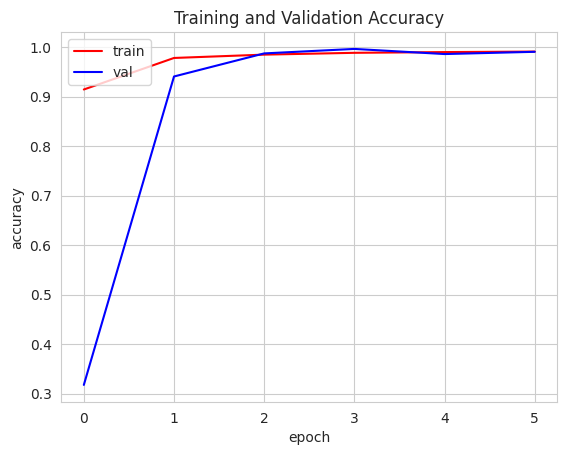

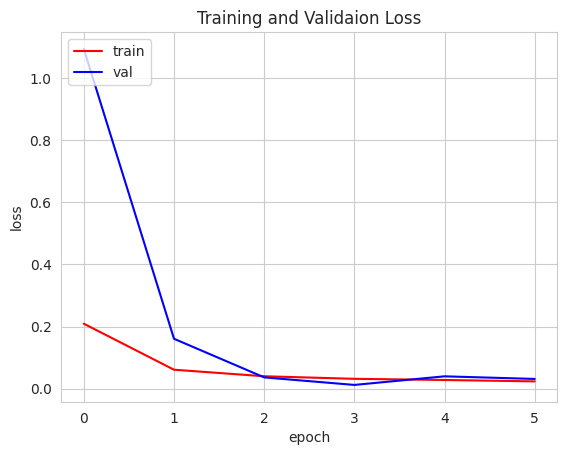

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

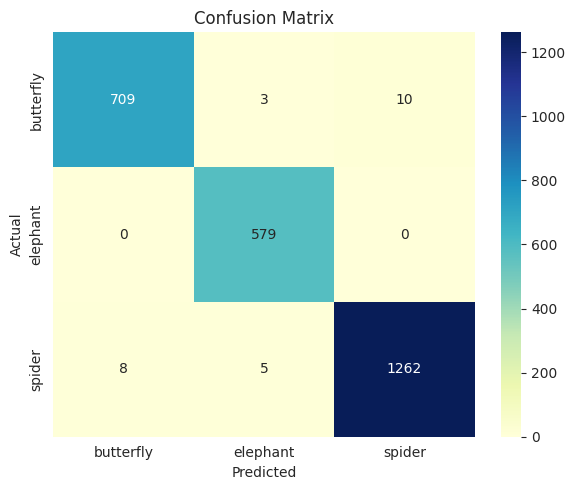


Classification Report:

              precision    recall  f1-score   support

   butterfly     0.9888    0.9820    0.9854       722
    elephant     0.9864    1.0000    0.9931       579
      spider     0.9921    0.9898    0.9910      1275

    accuracy                         0.9899      2576
   macro avg     0.9891    0.9906    0.9898      2576
weighted avg     0.9899    0.9899    0.9899      2576



In [23]:
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
y_pred = np.argmax(preds_1, axis=1)  

labels = test_generator.class_indices.keys() 
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred, target_names=labels, digits=4))

In [24]:
print(f"Final Training Accuracy: {acc[-1]}")
print(f"Final Validation Accuracy: {val_acc[-1]}")

Final Training Accuracy: 0.9907523393630981
Final Validation Accuracy: 0.9902849793434143


# Saving Model to .h5, .pb, tfjs, and tflite

---

In [25]:
model.save('/kaggle/working/submission/h5model/model.h5')

In [26]:
# .pb
model.export('/kaggle/working/submission/saved_model')
loaded_model = tf.saved_model.load('/kaggle/working/submission/saved_model')

Saved artifact at '/kaggle/working/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135856109099664: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135856109097552: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135853038414992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109102352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109064400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109103696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109068624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135852642331792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135852642331408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135852642332944: TensorSpec(shape=(), dtype=

In [27]:
# tflite

model = load_model("/kaggle/working/submission/h5model/model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Bikin foldernya kalau belum ada
os.makedirs("/kaggle/working/submission/tflite", exist_ok=True)

with open("/kaggle/working/submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)
    
classes = ["butterfly", "elephant", "spider"]  

with open("/kaggle/working/submission/tflite/label.txt", "w") as label_file:
    for label in classes:
        label_file.write(f"{label}\n")


Saved artifact at '/tmp/tmp3z5eayqv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135856109106768: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135856109094480: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135856109099856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109099088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109104272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109098128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109103888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109108112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109096784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135856109105616: TensorSpec(shape=(), dtype=tf.resource, name=None)

W0000 00:00:1745826500.898531      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745826500.898566      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745826501.058459      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [28]:
# # tfjs
!tensorflowjs_converter --input_format=keras /kaggle/working/submission/h5model/model.h5 /kaggle/working/submission/tfjs_model

2025-04-28 07:48:24.532542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745826504.552667     382 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745826504.558911     382 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32


# Inference

---

Inference menggunakan .pb

In [29]:
loaded_model = tf.saved_model.load('/kaggle/working/submission/saved_model')
infer = loaded_model.signatures['serving_default']

def inference(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img).astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = infer(tf.convert_to_tensor(img_array))
    
    predicted_class = np.argmax(predictions['output_0'][0].numpy())
    confidence = np.max(predictions['output_0'][0].numpy())
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {classes[predicted_class]} with Confidence: {confidence:.2f}")
    plt.show()

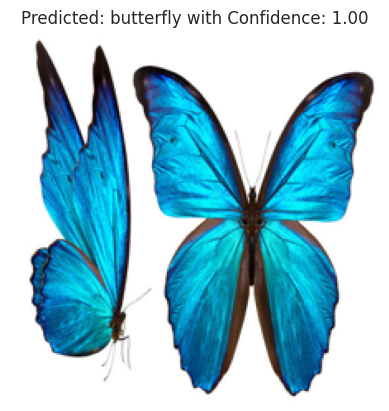

In [30]:
inference("https://t3.ftcdn.net/jpg/00/59/11/88/360_F_59118848_eqMNqMWmp8JHl62W61TB4bnj75xB6d3b.jpg")

# Creating Requirements

---

In [31]:
!pip freeze > /kaggle/working/submission/requirements.txt

# Saving notebook outputs to zip and create a download link

---

In [33]:
import shutil
from IPython.display import FileLink

shutil.make_archive('/kaggle/working/submission', 'zip', '/kaggle/working/submission')
FileLink(r'submission.zip')

/kaggle/working/submission.zip